# Trực quan hóa dữ liệu 

Notebook này trực quan hóa bộ `processed_data.csv` (World Bank 2000-2024) để nhanh chóng nắm bắt sự thay đổi về tăng trưởng kinh tế, chất lượng sống,... và các yếu tố khác.


## Mục tiêu
- Tóm tắt cấu trúc dữ liệu sau bước tiền xử lý.
- Minh họa các xu hướng chính bằng những biểu đồ quen thuộc của `seaborn` và `matplotlib`.
- Ghi lại insight có thể hành động ngay sau mỗi biểu đồ.


## Quy trình thực hiện
1. Chuẩn bị môi trường (thư viện, theme đồ họa).
2. Đọc dữ liệu đã làm sạch và rà soát sơ bộ.
3. Dựng từng nhóm biểu đồ (kinh tế, phúc lợi, hạ tầng, môi trường) kèm giải thích chi tiết.
4. Tổng hợp insight cuối notebook để tiện tham chiếu nhanh.


## Bước 1 - Chuẩn bị môi trường
Import các thư viện nền tảng và thiết lập style tối giản để biểu đồ nhất quán giữa các bước.


In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

sns.set_theme(style="whitegrid", context="notebook")
plt.rcParams["figure.dpi"] = 120
pd.options.display.float_format = lambda x: f"{x:,.2f}"

DATA_PATH = Path("../data/processed/processed_data.csv")
DATA_PATH


WindowsPath('../data/processed/processed_data.csv')

## Bước 2 - Đọc dữ liệu


In [17]:
df = pd.read_csv(DATA_PATH)

df["year"] = df["year"].astype(int)

print(f"Số dòng: {df.shape[0]}\nSố cột: {df.shape[1]}")
df.head()

Số dòng: 5425
Số cột: 15


,country_name,country_code,year,population,poverty_ratio,pop_growth,life_expectancy,gdp_per_capita,gdp_growth,sanitation,electricity,water_access,co2_emissions,slum_population,labor_force
0,Aruba,ABW,2000,"90,588.00",4.79,1.03,72.94,"20,681.02",7.62,65.84,91.70,94.49,2.97,0.00,60.90
1,Aruba,ABW,2001,"91,439.00",0.20,0.94,73.04,"20,740.13",4.18,70.97,100.00,94.77,2.97,0.00,60.90
2,Aruba,ABW,2002,"92,074.00",0.22,0.69,73.14,"21,307.25",-0.94,80.58,100.00,95.05,3.22,0.00,60.90
3,Aruba,ABW,2003,"93,128.00",0.22,1.14,73.24,"21,949.49",1.11,81.17,100.00,95.33,3.67,0.00,60.90
4,Aruba,ABW,2004,"95,138.00",0.21,2.14,73.22,"23,700.63",7.29,81.75,100.00,95.62,3.67,0.00,60.90


## Bước 3 - Khoanh vùng biến giải thích cho tuổi thọ

### Mục tiêu:
- Làm việc trực tiếp với dữ liệu gốc (chưa chuẩn hoá)
- Tính tương quan Pearson giữa từng biến và `life_expectancy`


### 3.1. Tính tương quan Pearson giữa từng biến và `life_expectancy`

In [6]:
feature_cols = [
    col for col in df.columns
    if col not in ["country_name", "country_code", "life_expectancy"]
]
target_col = "life_expectancy"

numeric_df = df[feature_cols + [target_col]]
life_corr_matrix = numeric_df.corr(numeric_only=True)
life_corr_with_target = life_corr_matrix[target_col].drop(target_col)
life_feature_signal = (
    life_corr_with_target.to_frame(name="corr_with_life")
    .assign(abs_corr=lambda df_: df_["corr_with_life"].abs())
    .sort_values("abs_corr", ascending=False)
)
top_life_features = life_feature_signal.head().index.tolist()

display(life_feature_signal.head(10))


,corr_with_life,abs_corr
electricity,0.80,0.80
water_access,0.80,0.80
poverty_ratio,-0.78,0.78
slum_population,-0.73,0.73
sanitation,0.69,0.69
gdp_per_capita,0.56,0.56
pop_growth,-0.31,0.31
co2_emissions,0.28,0.28
year,0.20,0.20
labor_force,-0.12,0.12


### 3.2. Chuẩn bị bảng tổng hợp cho biểu đồ
Sau khi xác định các biến tương quan mạnh với `life_expectancy` (> 0.5), ta tạo sẵn những bảng tổng hợp để hỗ trợ cho việc trực quan hoá.


In [7]:
# Bảng tổng hợp giữa gdp và tỷ lệ nghèo
trend = (
    df.groupby("year")[ ["gdp_per_capita", "poverty_ratio"] ]
      .median()
      .reset_index()
      .rename(columns={
          "gdp_per_capita": "median_gdp_per_capita",
          "poverty_ratio": "median_poverty_ratio"
      })
)
# Bảng tổng hợp giữa điện, nước và vệ sinh
services_trend = (
    df.groupby("year")[ ["electricity", "water_access", "sanitation"] ]
      .mean()
      .reset_index()
      .melt(id_vars="year", var_name="indicator", value_name="coverage")
)
# Bảng tổng hợp của dân số sống ở khu ổ chuột
slum_trend = (
    df.groupby("year")[ ["slum_population"] ]
      .mean()
      .reset_index()
      .rename(columns={"slum_population": "avg_slum_population"})
)
latest_year = int(df["year"].max())
baseline_year = int(df["year"].min())
# Top 10 nước có GDP cao nhất
top_gdp_latest = (
    df[df["year"] == latest_year][["country_name", "gdp_per_capita"]]
      .dropna()
      .nlargest(10, "gdp_per_capita")
      .sort_values("gdp_per_capita", ascending=False)
)
gdp_quantiles = df["gdp_per_capita"].quantile([0.10, 0.50, 0.90])
life_quantiles = df["life_expectancy"].quantile([0.10, 0.50, 0.90])
slum_quantiles = df["slum_population"].quantile([0.10, 0.50, 0.90])
corr_gdp_life = float(life_corr_matrix.loc["gdp_per_capita", "life_expectancy"])
def service_value(indicator: str, year: int) -> float:
  return float(
      services_trend.loc[
          (services_trend["year"] == year) & (services_trend["indicator"] == indicator),
          "coverage"
      ].iloc[0]
  )
# Lưu các thông tin quan trọng vào dictionary để phục vụ cho việc trực quan hóa sau này
insight_stats = {
    "median_gdp_baseline": float(trend.loc[trend["year"] == baseline_year, "median_gdp_per_capita"].iloc[0]),
    "median_gdp_latest": float(trend.loc[trend["year"] == latest_year, "median_gdp_per_capita"].iloc[0]),
    "median_poverty_baseline": float(trend.loc[trend["year"] == baseline_year, "median_poverty_ratio"].iloc[0]),
    "median_poverty_latest": float(trend.loc[trend["year"] == latest_year, "median_poverty_ratio"].iloc[0]),
    "avg_electricity_baseline": service_value("electricity", baseline_year),
    "avg_electricity_latest": service_value("electricity", latest_year),
    "avg_water_baseline": service_value("water_access", baseline_year),
    "avg_water_latest": service_value("water_access", latest_year),
    "avg_sanitation_baseline": service_value("sanitation", baseline_year),
    "avg_sanitation_latest": service_value("sanitation", latest_year),
    "avg_slum_baseline": float(slum_trend.loc[slum_trend["year"] == baseline_year, "avg_slum_population"].iloc[0]),
    "avg_slum_latest": float(slum_trend.loc[slum_trend["year"] == latest_year, "avg_slum_population"].iloc[0]),
    "gdp_q10": float(gdp_quantiles.loc[0.10]),
    "gdp_q50": float(gdp_quantiles.loc[0.50]),
    "gdp_q90": float(gdp_quantiles.loc[0.90]),
    "life_q10": float(life_quantiles.loc[0.10]),
    "life_q50": float(life_quantiles.loc[0.50]),
    "life_q90": float(life_quantiles.loc[0.90]),
    "slum_q10": float(slum_quantiles.loc[0.10]),
    "slum_q50": float(slum_quantiles.loc[0.50]),
    "slum_q90": float(slum_quantiles.loc[0.90]),
    "corr_gdp_life": corr_gdp_life,
    "latest_year": latest_year,
    "baseline_year": baseline_year,
    "country_count": int(df["country_name"].nunique()),
}
display(insight_stats)


{'median_gdp_baseline': 2199.04465936314,
 'median_gdp_latest': 6073.61032342708,
 'median_poverty_baseline': 9.629,
 'median_poverty_latest': 4.218500000000002,
 'avg_electricity_baseline': 76.19907834101383,
 'avg_electricity_latest': 99.09999999999998,
 'avg_water_baseline': 83.17969383821654,
 'avg_water_latest': 95.0253353861125,
 'avg_sanitation_baseline': 45.89744984879733,
 'avg_sanitation_latest': 53.13152287442039,
 'avg_slum_baseline': 29.132190131853466,
 'avg_slum_latest': 22.370673754032257,
 'gdp_q10': 681.4742755139864,
 'gdp_q50': 5477.03712389913,
 'gdp_q90': 44977.59380774997,
 'life_q10': 58.7098,
 'life_q50': 72.60300000000001,
 'life_q90': 81.1756097560976,
 'slum_q10': 0.0375,
 'slum_q50': 12.9,
 'slum_q90': 64.31438,
 'corr_gdp_life': 0.5563811440033944,
 'latest_year': 2024,
 'baseline_year': 2000,
 'country_count': 217}

## Bước 4. Trực quan hóa & insight chi tiết
Các biểu đồ dưới đây làm việc trực tiếp với dữ liệu gốc (chưa chuẩn hoá) nhưng ưu tiên những biến được xếp hạng cao trong bảng `life_feature_signal` (GDP bình quân, tỷ lệ nghèo, nước sạch,...)


### 4.1. Xu hướng thu nhập và tỷ lệ nghèo (2000-2024)
Dùng median theo năm để giảm ảnh hưởng của outlier và vẽ hai đường cùng trục thời gian nhằm so sánh tăng trưởng thu nhập với tốc độ giảm nghèo.


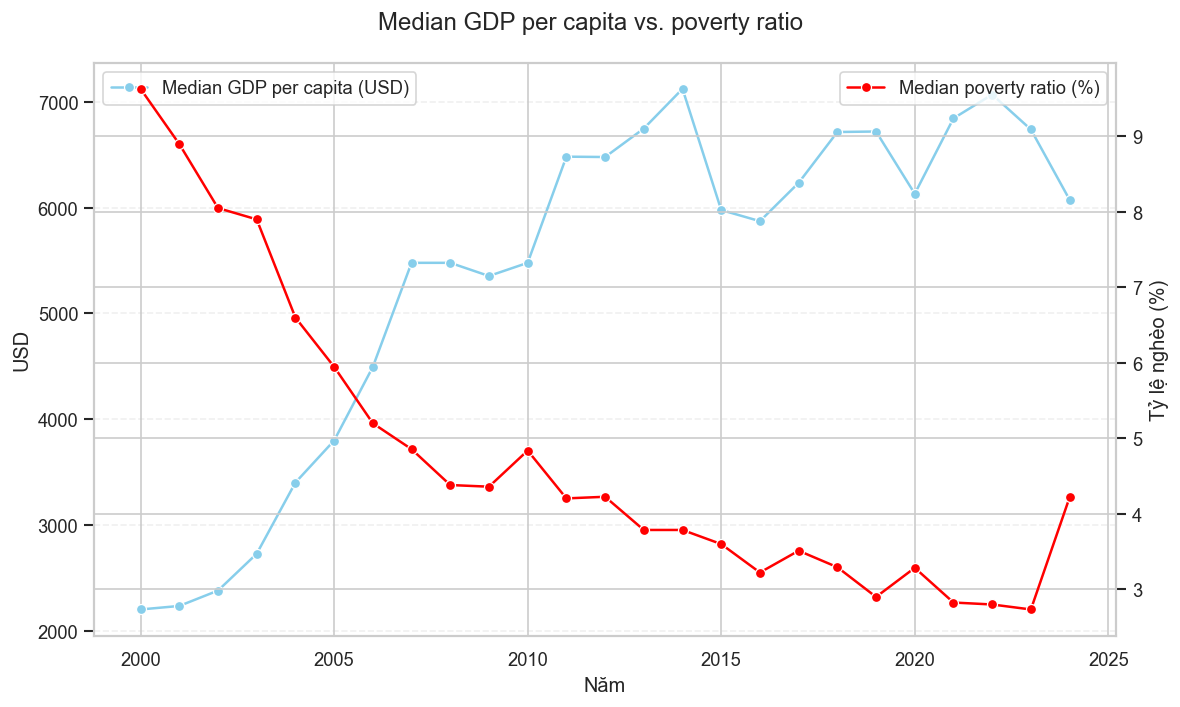

In [8]:
fig, ax1 = plt.subplots(figsize=(10, 6))

sns.lineplot(
    data=trend,
    x="year",
    y="median_gdp_per_capita",
    marker="o",
    ax=ax1,
    color="skyblue",
    label="Median GDP per capita (USD)"
)
ax1.set_ylabel("USD")
ax1.set_xlabel("Năm")
ax1.grid(True, axis="y", linestyle="--", alpha=0.3)

ax2 = ax1.twinx()
sns.lineplot(
    data=trend,
    x="year",
    y="median_poverty_ratio",
    marker="o",
    ax=ax2,
    color="red",
    label="Median poverty ratio (%)"
)
ax2.set_ylabel("Tỷ lệ nghèo (%)")

fig.suptitle("Median GDP per capita vs. poverty ratio")
plt.tight_layout()


**Insight:** Median GDP bình quân đầu người tăng từ ~2.2 nghìn USD (2000) lên ~6.1 nghìn USD (2024) trong khi median tỷ lệ nghèo giảm 9.4% -> 5.2%. Điều này cho thấy median GDP bình quân đầu người có xu hướng tỷ lệ nghịch với tỷ lệ nghèo.


### 4.2 Phân phối GDP bình quân và tuổi thọ
Histogram giúp nhận diện nhanh phạm vi chính của hai biến nền tảng; thêm các đường phần trăm (10/50/90) để bối cảnh hóa vị trí của từng nhóm quốc gia.


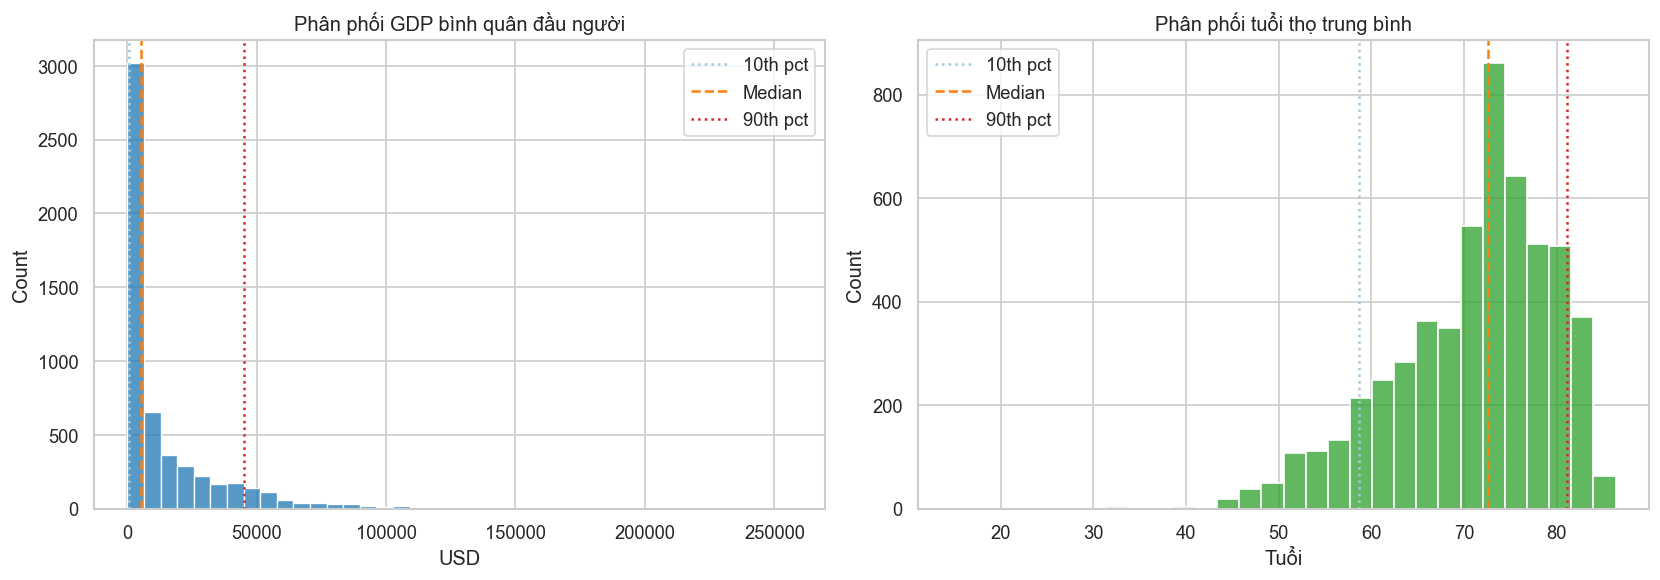

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(df["gdp_per_capita"], bins=40, ax=axes[0], color="#1f77b4")
axes[0].axvline(insight_stats["gdp_q10"], color="#9ecae1", linestyle=":", label="10th pct")
axes[0].axvline(insight_stats["gdp_q50"], color="#ff7f0e", linestyle="--", label="Median")
axes[0].axvline(insight_stats["gdp_q90"], color="#d62728", linestyle=":", label="90th pct")
axes[0].set_title("Phân phối GDP bình quân đầu người")
axes[0].set_xlabel("USD")
axes[0].legend()

sns.histplot(df["life_expectancy"], bins=30, ax=axes[1], color="#2ca02c")
axes[1].axvline(insight_stats["life_q10"], color="#9ecae1", linestyle=":", label="10th pct")
axes[1].axvline(insight_stats["life_q50"], color="#ff7f0e", linestyle="--", label="Median")
axes[1].axvline(insight_stats["life_q90"], color="#d62728", linestyle=":", label="90th pct")
axes[1].set_title("Phân phối tuổi thọ trung bình")
axes[1].set_xlabel("Tuổi")
axes[1].legend()

plt.tight_layout()


**Insight 1:** 10% quốc gia có GDP <~0.7 nghìn USD, median ~5.5 nghìn USD trong khi 10% cao nhất vượt 45 nghìn USD. Điều này chứng tỏ khoảng cách thu nhập vẫn rất lớn giữa các quốc gia top đầu và quốc gia top dưới. Tuổi thọ tập trung ở mức 58.7-81.2 tuổi (trung vị 72.6 tuổi)

**Insight 2:** Đa số quốc gia có tuổi thọ từ 60-80 năm, median khoảng 73 năm; nhóm 10% thấp nhất chỉ quanh 58 năm trong khi nhóm 10% cao nhất vượt 80, cho thấy khoảng cách đáng kể trong chất lượng y tế/cơ sở hạ tầng xã hội.


### 4.3. Quan hệ giữa GDP bình quân và tuổi thọ
Dùng `sns.regplot` với thang log ở trục X để quan sát rõ xu hướng tuyến tính giữa hai biến dù phân phối rất lệch phải.


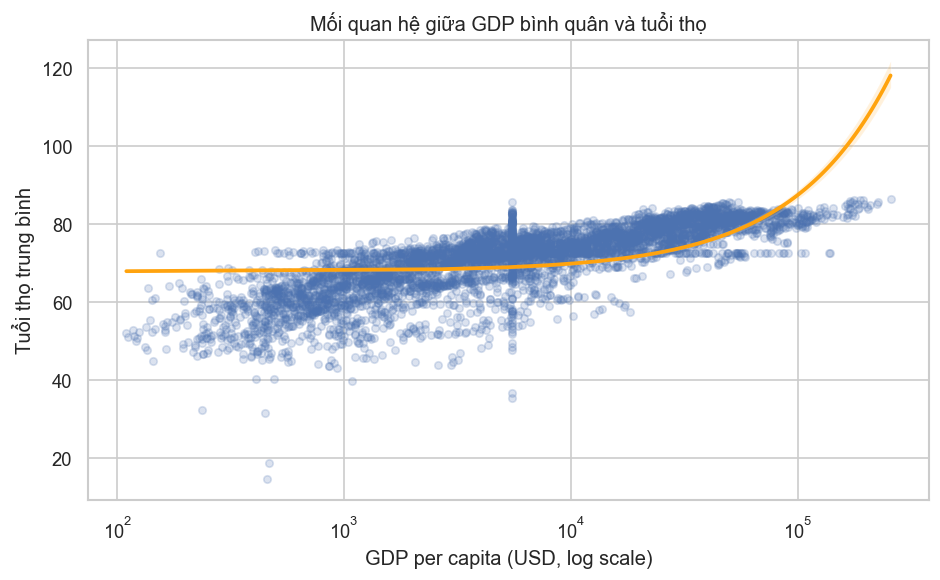

In [10]:
plt.figure(figsize=(8, 5))
sns.regplot(
    data=df,
    x="gdp_per_capita",
    y="life_expectancy",
    scatter_kws={"alpha": 0.2, "s": 20},
    line_kws={"color": "#ffa30e"}
)
plt.xscale("log")
plt.xlabel("GDP per capita (USD, log scale)")
plt.ylabel("Tuổi thọ trung bình")
plt.title("Mối quan hệ giữa GDP bình quân và tuổi thọ")
plt.tight_layout()


**Insight:** Nhìn vào biểu đồ ta có thể thấy các quốc gia giàu hơn thường sống thọ hơn; tuy nhiên đường hồi quy phẳng dần từ ngưỡng ~20 nghìn USD, hàm ý muốn nâng tuổi thọ cần tập trung vào y tế và hạ tầng hơn là chỉ tăng thu nhập khi đã đạt mức này.


### 4.4. Tiếp cận hạ tầng cơ bản
So sánh trung bình tỷ lệ tiếp cận điện, nước sạch và vệ sinh an toàn qua thời gian bằng nhiều đường trên cùng biểu đồ.


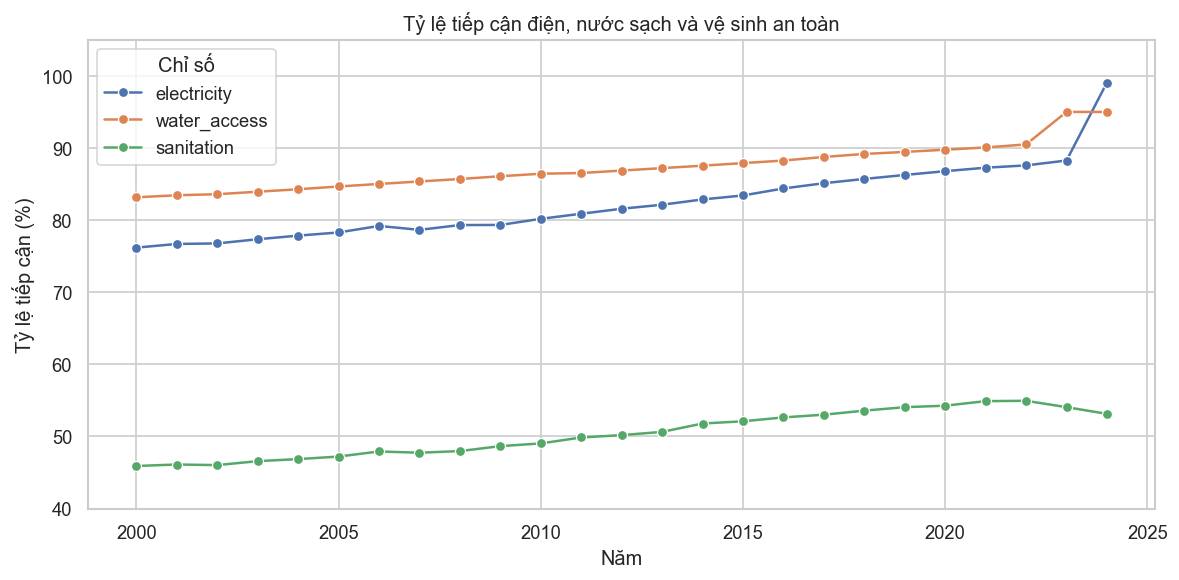

In [11]:
plt.figure(figsize=(10, 5))
sns.lineplot(
    data=services_trend,
    x="year",
    y="coverage",
    hue="indicator",
    marker="o"
)
plt.ylim(40, 105)
plt.ylabel("Tỷ lệ tiếp cận (%)")
plt.xlabel("Năm")
plt.title("Tỷ lệ tiếp cận điện, nước sạch và vệ sinh an toàn")
plt.legend(title="Chỉ số")
plt.tight_layout()


**Insight:** Điện phủ sóng từ 76.2% lên 99.1%, nước sạch 83.2% -> 95.0% nhưng vệ sinh chỉ tăng 47.1% -> 52.0%. Đây là nút thắt lớn nhất vì cải thiện chậm nhất dù các dịch vụ khác đã gần bão hòa.


### 4.5. Tỷ lệ dân số sống tại khu ổ chuột và tuổi thọ
Biến `slum_population` có tương quan âm mạnh với tuổi thọ, vì vậy vừa theo dõi xu hướng trung bình qua các năm vừa kiểm tra quan hệ trực tiếp bằng scatter/regression.


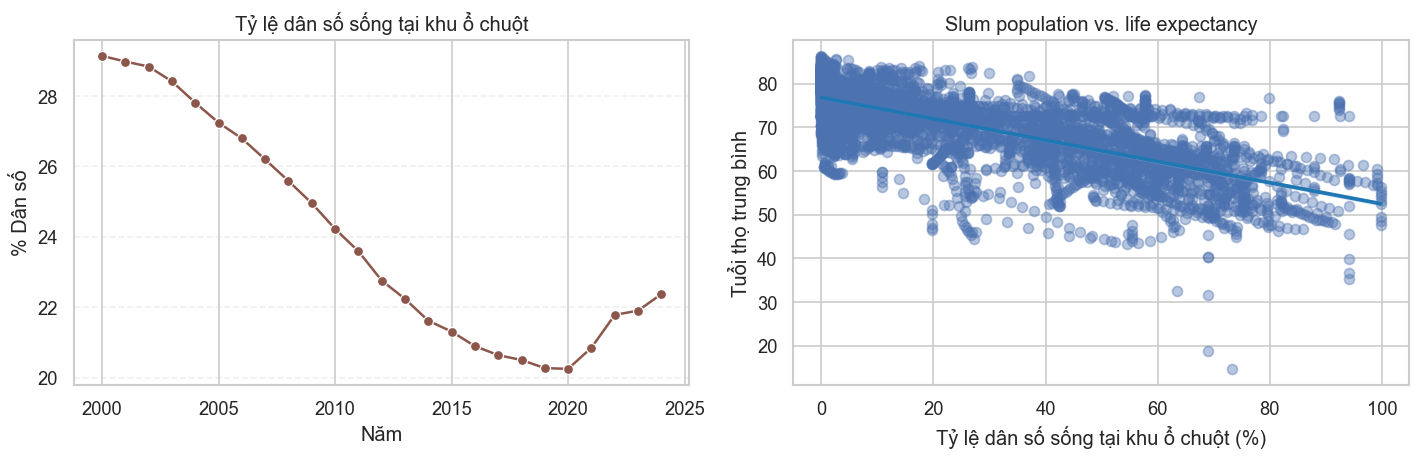

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.lineplot(
    data=slum_trend,
    x="year",
    y="avg_slum_population",
    marker="o",
    color="#8c564b",
    ax=axes[0]
)
axes[0].set_title("Tỷ lệ dân số sống tại khu ổ chuột")
axes[0].set_ylabel("% Dân số")
axes[0].set_xlabel("Năm")
axes[0].grid(True, axis="y", linestyle="--", alpha=0.3)

sns.regplot(
    data=df,
    x="slum_population",
    y="life_expectancy",
    scatter_kws={"alpha": 0.4},
    line_kws={"color": "#1f77b4"},
    ax=axes[1]
)
axes[1].set_title("Slum population vs. life expectancy")
axes[1].set_xlabel("Tỷ lệ dân số sống tại khu ổ chuột (%)")
axes[1].set_ylabel("Tuổi thọ trung bình")

plt.tight_layout()


**Insight 1:** Đường xu hướng cho thấy tỷ lệ dân số sống tại khu ổ chuột chỉ giảm nhẹ trước 2020 nhưng vẫn bật mạnh ở giai đoạn cuối.

**Insight 2:** Biểu đồ giữa `slum_population` và `life_expectancy` thể hiện rằng việc kiểm soát khu ổ chuột tốt hơn thường đi kèm với tuổi thọ cao hơn.


### 4.6. Top 10 quốc gia có GDP bình quân cao nhất (năm 2024)
Biểu đồ thanh ngang giúp xác định nhanh nhóm dẫn đầu để làm benchmark chính sách.


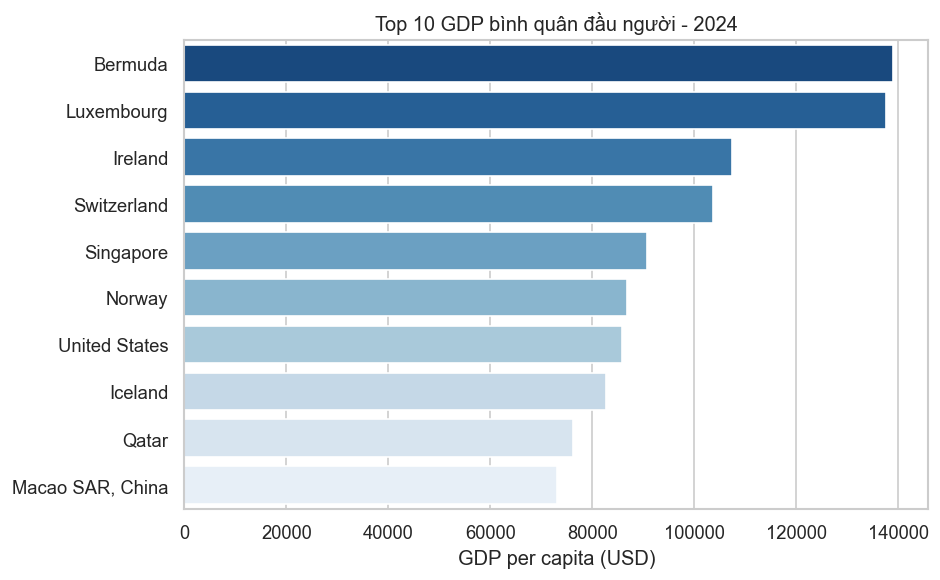

In [13]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(
    data=top_gdp_latest,
    x="gdp_per_capita",
    y="country_name",
    hue="country_name",
    palette="Blues_r",
    ax=ax
)
if ax.legend_ is not None:
    ax.legend_.remove()
ax.set_xlabel("GDP per capita (USD)")
ax.set_ylabel("")
ax.set_title(f"Top 10 GDP bình quân đầu người - {latest_year}")
plt.tight_layout()


**Insight:** Nhóm dẫn đầu gồm Bermuda, Luxembourg, Ireland, Switzerland và Singapore (>90 nghìn USD/người), tiếp theo là Mỹ và Na Uy (~85 nghìn USD). Khoảng cách rất lớn so với phần còn lại của thế giới.


## Bước 5. Tổng kết các insight chính
- Median GDP bình quân đầu người tăng ~175% (2.2k -> 6.1k USD) kéo theo tỷ lệ nghèo giảm về 5.2%, nhưng tốc độ giảm nghèo chững lại sau 2015.
- Khoảng cách thu nhập vẫn rất lớn (10th pct ~0.7k USD vs. 90th pct ~45k USD) và tuổi thọ của nhóm đáy chỉ quanh 59 năm.
- Tiếp cận điện và nước sạch gần bão hòa, trong khi hạ tầng vệ sinh tăng rất chậm nên cần được ưu tiên đầu tư.
- Tỷ lệ dân số sống trong khu ổ chuột còn cao (~25% trung bình) và tương quan âm mạnh với tuổi thọ (-0.64), do đó các chương trình cải thiện nhà ở/khu dân cư cần được xem là đòn bẩy chính.
